## Calculating return period for cyclones in Madagascar



We're looking to calculate the return period for cyclones of a given threshold speed in Madagascar.
- An overall return period across the country
- A return period across some selected regions. The new admin boundaries to be confirmed by Rija.

In [3]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [4]:
import geopandas as gpd
import pandas as pd
from pathlib import Path
from shapely.geometry import LineString
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from src import constants, utils

## Data loading and preparation

[Tropical Cyclone Scales](https://en.wikipedia.org/wiki/Tropical_cyclone_scales#South-West_Indian_Ocean)


In [5]:
adm0_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm0_BNGRC_OCHA_20181031.shp"
)
gdf_adm0 = gpd.read_file(adm0_path)
adm1_path = (
    Path(constants.AA_DATA_DIR)
    / "public"
    / "raw"
    / "mdg"
    / "cod_ab"
    / "mdg_admbnda_adm1_BNGRC_OCHA_20181031.shp"
)
gdf_adm1 = gpd.read_file(adm1_path)
ibtracs_path = adm1_path = (
    Path(constants.AA_DATA_DIR) / "public" / "raw" / "glb" / "ibtracs"
)
points_path = Path(
    ibtracs_path
    / "IBTrACS.SI.list.v04r01.points/IBTrACS.SI.list.v04r01.points.shp"
)

gdf_points = gpd.read_file(points_path)

In [6]:
gdf_points.loc[:, "Season"] = gdf_points.apply(
    lambda x: (
        f"{x['year'] - 1}-{x['year']}"
        if x["month"] <= 6
        else f"{x['year']}-{x['year'] + 1}"
    ),
    axis=1,
)

<Axes: >

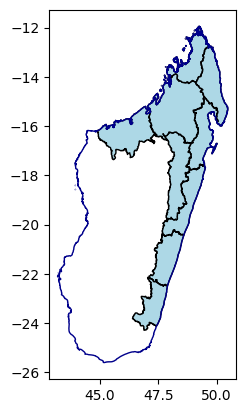

In [7]:
gdf_adm1_sel = gdf_adm1[gdf_adm1["ADM1_EN"].isin(constants.ADMS)]
ax = gdf_adm1_sel.plot(color="lightblue", edgecolor="black")
gdf_adm0.plot(ax=ax, color="none", edgecolor="darkblue", linewidth=1)

Country-Wide

In [8]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:29702)
    gdf_adm0_buffer = gdf_adm0.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm0_buffer["geometry"] = gdf_adm0_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm0_buffer = gdf_adm0_buffer.to_crs(gdf_adm0.crs)
else:
    gdf_adm0_buffer = gdf_adm0.copy()

In [9]:
gdf_points_sel = gpd.sjoin(
    gdf_points, gdf_adm0_buffer, how="inner", predicate="intersects"
)
gdf_points_sel_ = gdf_points_sel.sort_values("ISO_TIME")

<Axes: >

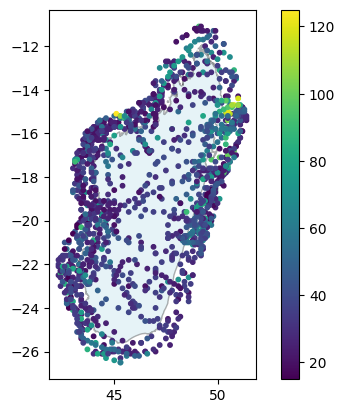

In [10]:
ax = gdf_adm0.plot(color="lightblue", edgecolor="black", alpha=0.3)
gdf_points_sel_.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

Selected Regions

In [16]:
buffer = True
if buffer:
    # Create buffer around gdf_adm0 with the given distance
    # Reproject to a CRS that uses meters (e.g., EPSG:29702)
    gdf_adm1_buffer = gdf_adm1_sel.to_crs(epsg=constants.mdg_epsg)

    # Apply the buffer of 100 km (100,000 meters)
    gdf_adm1_buffer["geometry"] = gdf_adm1_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km = 100,000 meters

    # Reproject back to the original CRS
    gdf_adm1_buffer = gdf_adm1_buffer.to_crs(gdf_adm1.crs)
else:
    gdf_adm1_buffer = gdf_adm1_sel.copy()
gdf_points_sel_adm1 = gpd.sjoin(
    gdf_points, gdf_adm1_buffer, how="inner", predicate="intersects"
)
gdf_points_sel_adm1 = gdf_points_sel_adm1.sort_values("ISO_TIME")

<Axes: >

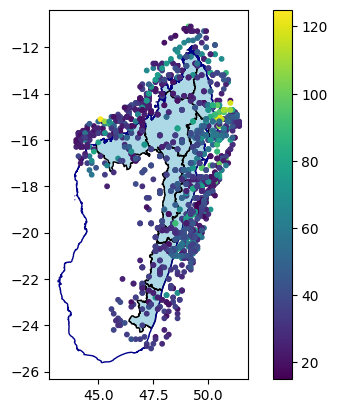

In [12]:
ax = gdf_adm1_sel.plot(color="lightblue", edgecolor="black")
gdf_adm0.plot(ax=ax, color="none", edgecolor="darkblue", linewidth=1)
gdf_points_sel_adm1.plot(ax=ax, column="REU_WIND", markersize=10, legend=True)

## Return period calculation


In [13]:
# combining US Wind and REUnion for those with no wind speed
# we are not using this for MDG
gdf_points_sel_["REU_USA_WIND"] = gdf_points_sel_["REU_WIND"].fillna(
    gdf_points_sel_["USA_WIND"]
    * constants.minute_to_10_minute_conversion_factor
)

In [14]:
df = gdf_points_sel_[
    gdf_points_sel_["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )
    >= 1980
]
df["NAME"].unique()

array(['UNNAMED', 'HYACINTHE', 'KOLIA', 'BERT:CHRISTE', 'EDWIG',
       'HELYETTE', 'IADINE', 'JOHANNE', 'KLARA', 'BENEDICTE', 'FRIDA',
       'ELECTRE', 'JUSTINE', 'FELY', 'ANDRY', 'CABOTO', 'DOMOINA', 'GALY',
       'KAMISY', 'ANETY', 'ESITERA', 'FELIKSA', 'HELISAONINA', 'ALIFREDY',
       'GISTA', 'HONORININA', 'ELIZABETHA', 'BENANDRO', 'CALIDERA',
       'DOAZA', 'FILAO', 'HELY', 'CALASANJY', 'IANA', 'JINABO', 'ALIBERA',
       'HANTA', 'CYNTHIA', 'BRYNA', 'DESSILIA', 'FINELLA', 'GRACIA',
       'HUTELLE', 'IONIA', 'DAISY', 'GERALDA', 'JULITA', 'KELVINA',
       'LITANNE', 'NADIA', 'CHRISTELLE', 'JOSTA', 'BONITA', 'DOLORESSE',
       'EDWIGE', 'FABRIOLA', 'GRETELLE', 'JOSIE', 'BELTANE', 'DAVINA',
       'ASTRIDE', 'ELINE:LEONE', 'GLORIA', 'HUDAH', 'DERA', 'CYPRIEN',
       'GUILLAUME', 'HARY', 'KESINY', 'ATANG', 'DELFINA', 'FARI',
       'JAPHET', 'MANOU', 'CELA', 'ELITA', 'GAFILO', 'BENTOJANA',
       'ERNEST', 'FELAPI', 'BOLOETSE', 'BONDO', 'CLOVIS', 'ENOK', 'FAVIO',
       'INDL

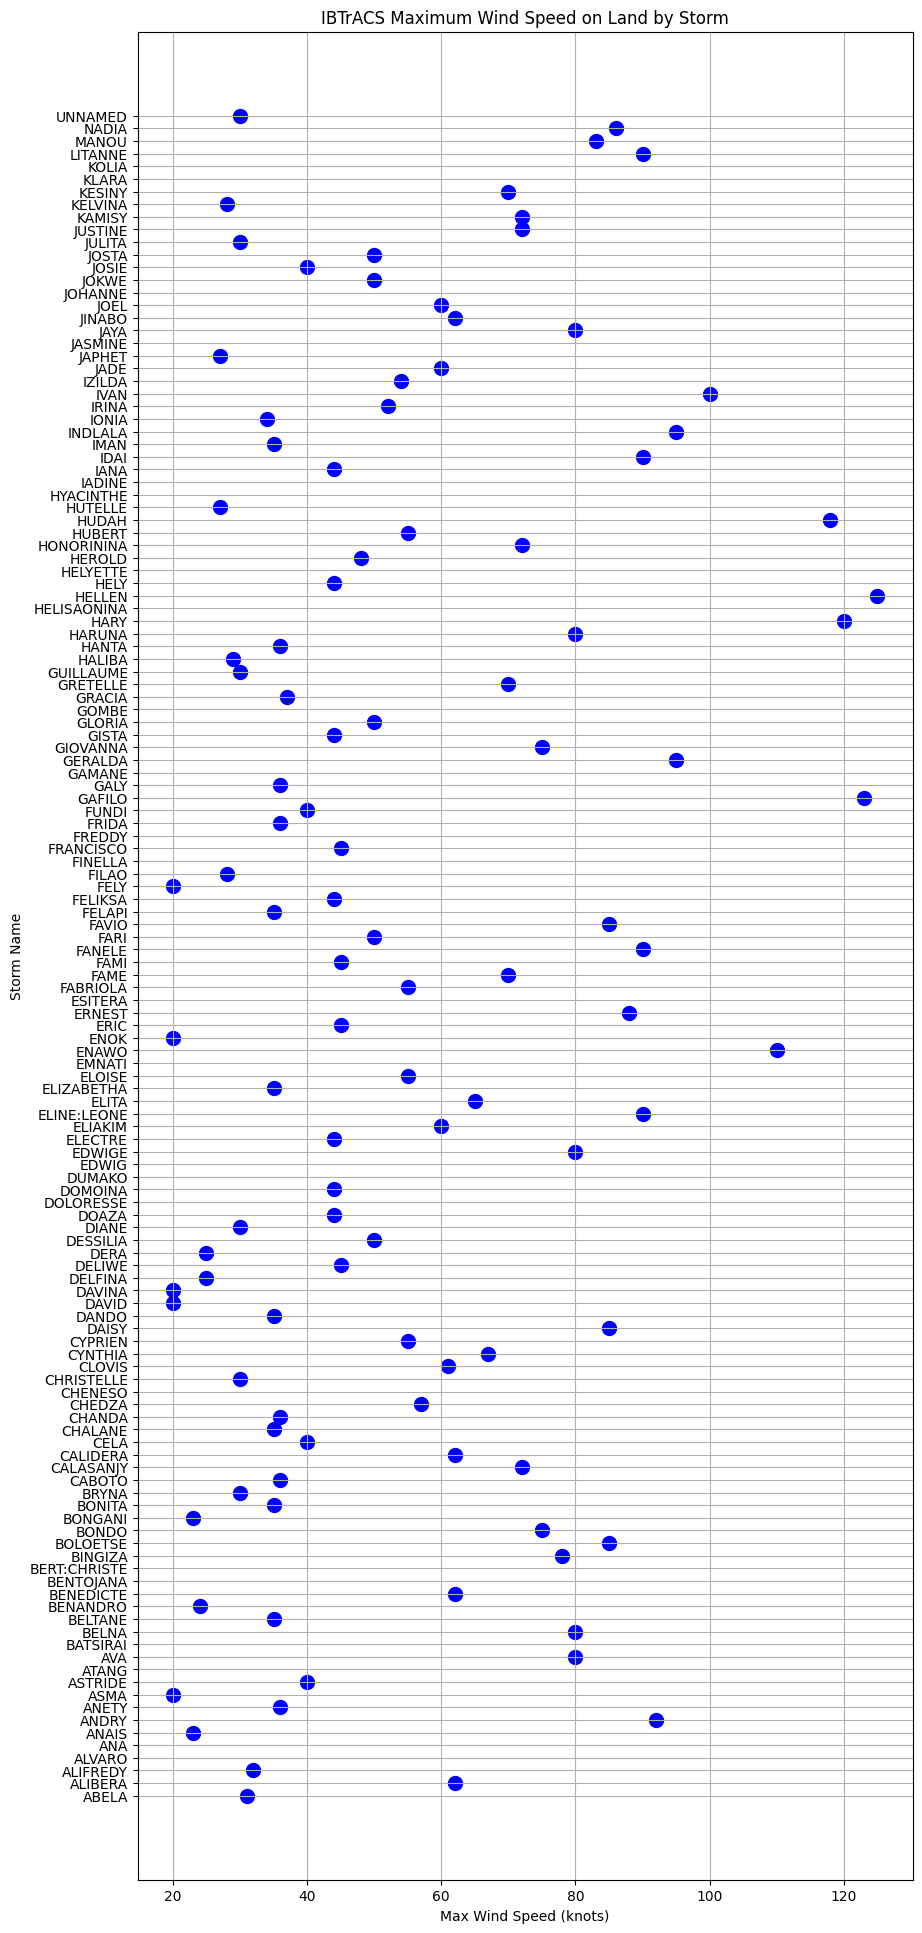

In [15]:
max_values = df.groupby("NAME")["REU_WIND"].max().reset_index()

# Step 3: Plot the maximum values as points for each category
plt.figure(figsize=(10, 24))
plt.scatter(
    max_values["REU_WIND"],
    max_values["NAME"],
    color="blue",
    s=100,
    label="Max Wind Speed",
)

# Adding labels and title
plt.ylabel("Storm Name")
plt.xlabel("Max Wind Speed (knots)")
plt.title("IBTrACS Maximum Wind Speed on Land by Storm")
plt.grid(True)
plt.show()

### Country-Wide

#### Since 1980

Scenario 2 with an upper bound

In [17]:
# Scenario 2
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-1.8 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [18]:
# 118 km/h or higher
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-1.8 years.


Scenario 3 

In [ ]:
# Scenario 3
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2000,
)

The combined return period of storms over 166km/h is 1-in-3.0 years.


#### Since 2006

Scenario 2 with an upper bound

In [18]:
# Scenario 2
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=2006,
)

The combined return period of storms over 118km/h is 1-in-1.6 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [19]:
# 118 km/h or higher
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2006,
)

The combined return period of storms over 118km/h is 1-in-1.6 years.


Scenario 3 

In [20]:
# Scenario 3
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2006,
)

The combined return period of storms over 166km/h is 1-in-3.2 years.


#### Since 2000

Scenario 2 with an upper bound

In [26]:
# Scenario 2
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=2001,
)

The combined return period of storms over 118km/h is 1-in-1.5 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [27]:
# 118 km/h or higher
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2001,
)

The combined return period of storms over 118km/h is 1-in-1.5 years.


Scenario 3 

Using 2001 here since no storms in the 2000-2001 season meet Scenario 3.

In [28]:
# Scenario 3
utils.calculate_storm_return_period(
    df=gdf_points_sel_,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2001,
)

The combined return period of storms over 166km/h is 1-in-3.0 years.


In [24]:
# Filter data from 1980 onwards
df_filtered = gdf_points_sel_[gdf_points_sel_["Season"] >= "1980"]
# Define wind speed thresholds
threshold_64 = 64
threshold_90 = 90

df_filtered[
    (df_filtered["REU_WIND"] >= threshold_64)
    & (df_filtered["REU_WIND"] < threshold_90)
][["NAME", "Season"]].drop_duplicates()

,NAME,Season
105360,JUSTINE,1981-1982
108140,KAMISY,1983-1984
111126,HONORININA,1985-1986
114019,CALASANJY,1988-1989
117597,CYNTHIA,1990-1991
121110,DAISY,1993-1994
122163,NADIA,1993-1994
125303,EDWIGE,1995-1996
128048,GRETELLE,1996-1997
132765,ELINE:LEONE,1999-2000


In [25]:
df_filtered[(df_filtered["REU_WIND"] >= threshold_90)][
    ["NAME", "Season"]
].drop_duplicates()

,NAME,Season
106475,ANDRY,1983-1984
121417,GERALDA,1993-1994
121846,LITANNE,1993-1994
132767,ELINE:LEONE,1999-2000
133613,HUDAH,1999-2000
136575,HARY,2001-2002
139889,GAFILO,2003-2004
144155,INDLALA,2006-2007
145506,IVAN,2007-2008
146798,FANELE,2008-2009


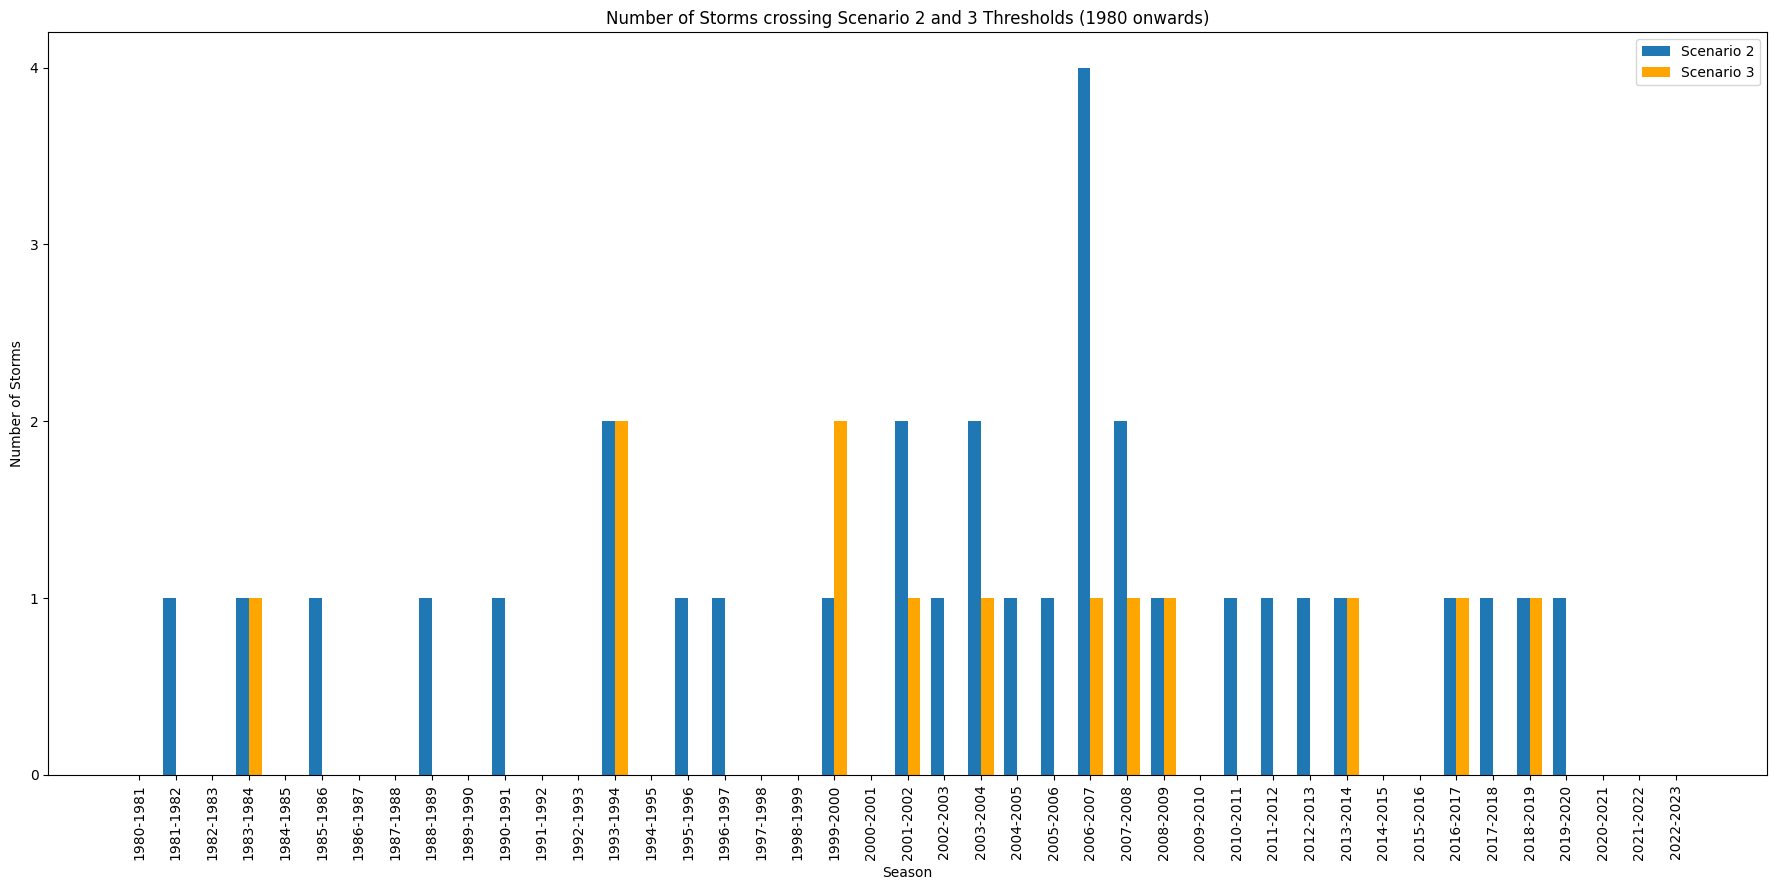

In [26]:
# Count storms above each threshold by season
storms_64 = (
    df_filtered[
        (df_filtered["REU_WIND"] >= threshold_64)
        & (df_filtered["REU_WIND"] < threshold_90)
    ]
    .groupby("Season")["SID"]
    .nunique()
)
storms_90 = (
    df_filtered[df_filtered["REU_WIND"] >= threshold_90]
    .groupby("Season")["SID"]
    .nunique()
)

# Combine counts into a single DataFrame for plotting with updated labels
storm_counts = pd.DataFrame(
    {"Scenario 2": storms_64, "Scenario 3": storms_90}
).fillna(0)

# Generate a full list of seasons from 1980 to the latest season in data
season_labels = [f"{year}-{year+1}" for year in range(1980, 2022 + 1)]
storm_counts = storm_counts.reindex(season_labels).fillna(
    0
)  # Reindex with all seasons

# Plot as a grouped bar chart
bar_width = 0.35
seasons = storm_counts.index
ind = range(len(seasons))  # x locations for the groups

plt.figure(figsize=(18, 9))
plt.bar(ind, storm_counts["Scenario 2"], width=bar_width, label="Scenario 2")
plt.bar(
    [i + bar_width for i in ind],
    storm_counts["Scenario 3"],
    width=bar_width,
    label="Scenario 3",
    color="orange",
)

# Add labels and title
plt.xlabel("Season")
plt.ylabel("Number of Storms")
plt.title(
    "Number of Storms crossing Scenario 2 and 3 Thresholds (1980 onwards)"
)
plt.xticks([i + bar_width / 2 for i in ind], seasons, rotation=90)
plt.legend()
plt.tight_layout()
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.show()

### Selected Regions

#### Since 1980

Scenario 2 with an upper bound

In [27]:
# Scenario 2
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-2.5 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [28]:
# 118 km/h or higher
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=1980,
)

The combined return period of storms over 118km/h is 1-in-2.5 years.


Scenario 3 

In [29]:
# Scenario 3
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=1980,
)

The combined return period of storms over 166km/h is 1-in-5.0 years.


#### Since 2006

Scenario 2 with an upper bound

In [30]:
# Scenario 2
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=166,
    start_year=2006,
)

The combined return period of storms over 118km/h is 1-in-2.4 years.


Scenario 2 with a high upper bound (Scenario 2 and 3)

In [31]:
# 118 km/h or higher
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=118,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2006,
)

The combined return period of storms over 118km/h is 1-in-2.4 years.


Scenario 3 

In [32]:
# Scenario 3
utils.calculate_storm_return_period(
    df=gdf_points_sel_adm1,
    wind_speed_kmh_min=166,
    wind_speed_kmh_max=300,  # high upper bound for testing
    start_year=2006,
)

The combined return period of storms over 166km/h is 1-in-4.8 years.


Looking at a possible 2.5 scenario for the entire country

In [33]:
def scenario_2_point_5(df, gdf_adm, start_year=1980):
    storm_data = []

    # Define thresholds for scenarios
    min_speed_knots = 118 * constants.kmh_to_knots
    max_speed_knots = 166 * constants.kmh_to_knots
    min_speed_knots_buffer = max_speed_knots  # 166 km/h in Scenario 3

    # Add 'year' column based on 'ISO_TIME'
    df.loc[:, "year"] = df["ISO_TIME"].apply(
        lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").year
    )

    # Scenario 2: Filter storms with 118-166 km/h wind speeds
    df_filtered_nobuffer = df.loc[
        (df["year"] >= start_year)
        & (df["REU_WIND"] >= min_speed_knots)
        & (df["REU_WIND"] < max_speed_knots)
    ]

    # Perform spatial join without buffer
    gdf_points_nobuffer = gpd.sjoin(
        df_filtered_nobuffer,
        gdf_adm,
        how="inner",
        predicate="intersects",
        rsuffix="admin",
    )

    # Collect storm data for Scenario 2
    for storm in gdf_points_nobuffer["NAME"].unique():
        storm_years = gdf_points_nobuffer[
            gdf_points_nobuffer["NAME"] == storm
        ][["year", "Season"]].drop_duplicates()
        for _, row in storm_years.iterrows():
            storm_data.append(
                {
                    "storm_name": storm,
                    "year": row["year"],
                    "season": row[
                        "Season"
                    ],  # Use season directly from gdf_points_nobuffer
                    "type": "Scenario 2 with no buffer",
                }
            )

    # Scenario 3: Filter storms with wind speeds >= 166 km/h with 100 km buffer
    gdf_adm_buffer = gdf_adm.to_crs(epsg=constants.mdg_epsg)
    gdf_adm_buffer["geometry"] = gdf_adm_buffer.geometry.buffer(
        constants.buffer * 1000
    )  # 100 km buffer
    gdf_adm_buffer = gdf_adm_buffer.to_crs(gdf_adm.crs)

    # Filter DataFrame for storms with 166 km/h or higher wind speeds
    df_filtered_buffer = df.loc[
        (df["year"] >= start_year) & (df["REU_WIND"] >= min_speed_knots_buffer)
    ]
    gdf_points_buffer = gpd.sjoin(
        df_filtered_buffer,
        gdf_adm_buffer,
        how="inner",
        predicate="within",
        rsuffix="admin",
    )

    # Collect storm data for Scenario 3
    for storm in gdf_points_buffer["NAME"].unique():
        storm_years = gdf_points_buffer[gdf_points_buffer["NAME"] == storm][
            ["year", "Season"]
        ].drop_duplicates()
        for _, row in storm_years.iterrows():
            storm_data.append(
                {
                    "storm_name": storm,
                    "year": row["year"],
                    "season": row[
                        "Season"
                    ],  # Use season directly from gdf_points_buffer
                    "type": "Scenario 3 with 100km buffer",
                }
            )

    # Convert storm data to DataFrame, remove duplicates, and calculate return period
    storm_data_df = pd.DataFrame(storm_data).drop_duplicates(
        subset=["storm_name", "season"]
    )
    yr_len = 2024 - start_year + 1
    combined_return_period = yr_len / storm_data_df["season"].nunique()

    print(
        f"The combined return period of storms is 1-in-{round(combined_return_period, 1)} years."
    )
    return storm_data_df

In [34]:
scenario_2_point_5(df=df, gdf_adm=gdf_adm0, start_year=1980)

C:\Users\pauni\AppData\Local\Temp\ipykernel_27296\3697230967.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1980 1980 1980 ... 2024 2024 2024]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df.loc[:, "year"] = df["ISO_TIME"].apply(


The combined return period of storms is 1-in-2.4 years.


,storm_name,year,season,type
0,NADIA,1994,1993-1994,Scenario 2 with no buffer
1,EDWIGE,1996,1995-1996,Scenario 2 with no buffer
2,GRETELLE,1997,1996-1997,Scenario 2 with no buffer
3,GAFILO,2004,2003-2004,Scenario 2 with no buffer
4,ERNEST,2005,2004-2005,Scenario 2 with no buffer
5,INDLALA,2007,2006-2007,Scenario 2 with no buffer
6,FAME,2008,2007-2008,Scenario 2 with no buffer
7,IVAN,2008,2007-2008,Scenario 2 with no buffer
8,FANELE,2009,2008-2009,Scenario 2 with no buffer
9,BINGIZA,2011,2010-2011,Scenario 2 with no buffer


In [35]:
scenario_2_point_5(df=df, gdf_adm=gdf_adm1_sel, start_year=1980)

The combined return period of storms is 1-in-3.2 years.


,storm_name,year,season,type
0,NADIA,1994,1993-1994,Scenario 2 with no buffer
1,EDWIGE,1996,1995-1996,Scenario 2 with no buffer
2,GRETELLE,1997,1996-1997,Scenario 2 with no buffer
3,GAFILO,2004,2003-2004,Scenario 2 with no buffer
4,INDLALA,2007,2006-2007,Scenario 2 with no buffer
5,IVAN,2008,2007-2008,Scenario 2 with no buffer
6,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
7,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
8,ENAWO,2017,2016-2017,Scenario 2 with no buffer
9,AVA,2018,2017-2018,Scenario 2 with no buffer


In [36]:
scenario_2_point_5(df=df, gdf_adm=gdf_adm0, start_year=2006)

The combined return period of storms is 1-in-1.7 years.


,storm_name,year,season,type
0,INDLALA,2007,2006-2007,Scenario 2 with no buffer
1,FAME,2008,2007-2008,Scenario 2 with no buffer
2,IVAN,2008,2007-2008,Scenario 2 with no buffer
3,FANELE,2009,2008-2009,Scenario 2 with no buffer
4,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
5,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
6,HARUNA,2013,2012-2013,Scenario 2 with no buffer
7,ENAWO,2017,2016-2017,Scenario 2 with no buffer
8,AVA,2018,2017-2018,Scenario 2 with no buffer
9,BELNA,2019,2019-2020,Scenario 2 with no buffer


In [37]:
scenario_2_point_5(df=df, gdf_adm=gdf_adm1_sel, start_year=2006)

The combined return period of storms is 1-in-2.7 years.


,storm_name,year,season,type
0,INDLALA,2007,2006-2007,Scenario 2 with no buffer
1,IVAN,2008,2007-2008,Scenario 2 with no buffer
2,BINGIZA,2011,2010-2011,Scenario 2 with no buffer
3,GIOVANNA,2012,2011-2012,Scenario 2 with no buffer
4,ENAWO,2017,2016-2017,Scenario 2 with no buffer
5,AVA,2018,2017-2018,Scenario 2 with no buffer
8,HELLEN,2014,2013-2014,Scenario 3 with 100km buffer


In [38]:
storm_data_df = scenario_2_point_5(df=df, gdf_adm=gdf_adm0, start_year=1980)

The combined return period of storms is 1-in-2.4 years.
